<a href="https://colab.research.google.com/github/aemiralfath/BPML-Dicoding/blob/master/submission1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import re
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


True

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
! pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir /root/.kaggle/
! cp "/content/drive/My Drive/Machine Learning/kaggle.json" /root/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

     |████████████████████████████████| 61kB 4.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=1958482b0a133a335db59b753e7b6a087239ca42586227be171154113888944b
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [4]:
!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp

  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 98.8MB/s]


In [5]:
zip_ref = zipfile.ZipFile('emotions-dataset-for-nlp.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [178]:
df_train = pd.read_csv('train.txt', names=['sentence', 'label'], sep=';')
df_test = pd.read_csv('test.txt', names=['sentence', 'label'], sep=';')
df_val = pd.read_csv('val.txt', names=['sentence', 'label'], sep=';')

In [179]:
df = df_train.append(df_test)
df = df.append(df_val)
df

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


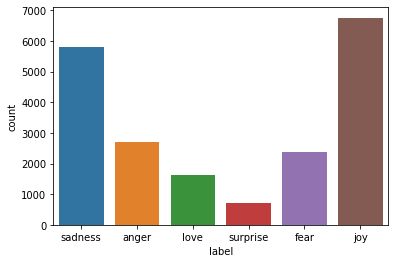

In [142]:
sns.countplot(df['label'])

In [180]:
# new_df = df[df['label']=='love']
# balance_length = len(new_df)
# print(balance_length)

# df_sadness = df[df['label']=='sadness']
# df_suprise = df[df['label']=='surprise']
# df_anger = df[df['label']=='anger']
# df_fear = df[df['label']=='fear']
# df_joy = df[df['label']=='joy']

# new_df = new_df.append(df_sadness[:balance_length])
# new_df = new_df.append(df_suprise)
# new_df = new_df.append(df_anger[:balance_length])
# new_df = new_df.append(df_fear[:balance_length])
# new_df = new_df.append(df_joy[:balance_length])
# print(len(new_df))

new_df = df

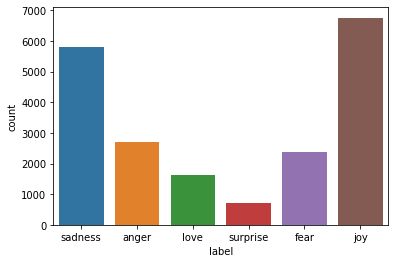

In [181]:
sns.countplot(new_df['label'])

In [182]:
category = pd.get_dummies(new_df['label'])
new_df = pd.concat([new_df, category], axis=1)
new_df = new_df.drop(columns='label')
new_df

,sentence,anger,fear,joy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0
...,...,...,...,...,...,...,...
1995,im having ssa examination tomorrow in the morn...,0,0,0,0,1,0
1996,i constantly worry about their fight against n...,0,0,1,0,0,0
1997,i feel its important to share this info for th...,0,0,1,0,0,0
1998,i truly feel that if you are passionate enough...,0,0,1,0,0,0


In [183]:
sw = stopwords.words('english')
stemmer = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

replace_puncts = {'`': "'", '′': "'", '“':'"', '”': '"', '‘': "'"}

strip_chars = [',', '.', '"', ':', ')', '(', '-', '|', ';', "'", '[', ']', '>', '=', '+', '\\', '•',  '~', '@', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

puncts = ['!', '?', '$', '&', '/', '%', '#', '*','£']

In [184]:
def clean_text(x):
    x = str(x)
    x = x.lower()
    x = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", x)
    for k, v in replace_puncts.items():
        x = x.replace(k, f' {v} ')
        
    for punct in strip_chars:
        x = x.replace(punct, ' ') 
    
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
        
    x = x.replace(" '", " ")
    x = x.replace("' ", " ")
    x = x.strip()
    return x

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    return " ".join(text)

def stemming(text):
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

def lemm(text):    
    text = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(text)

def clean_length(text):
    text = [word for word in text.split() if len(word) > 2]
    return " ".join(text)

def text_processing(X):
    X=X.apply(remove_stopwords)
    X=X.apply(clean_text)
    # X=X.apply(stemming)
    X=X.apply(lemm)
    X=X.apply(clean_length)
    return X

In [185]:
x = text_processing(new_df['sentence'])
y = new_df[['anger', 'fear',	'joy',	'love',	'sadness',	'surprise']].values

In [186]:
x_clean = x.values
x_clean

array(['didnt feel humiliated',
       'feeling hopeless damned hopeful around someone care awake',
       'grabbing minute post feel greedy wrong', ...,
       'feel important share info experience thing',
       'truly feel passionate enough something stay true succeed',
       'feel like wanna buy cute make see online even one'], dtype=object)

In [187]:
x_train, x_test, y_train, y_test = train_test_split(x_clean, y, test_size=0.2)

In [188]:
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)

sequence_train = tokenizer.texts_to_sequences(x_train)
sequence_test = tokenizer.texts_to_sequences(x_test)

padded_train = pad_sequences(sequence_train, padding='post', maxlen=30, truncating='post')
padded_test = pad_sequences(sequence_test, padding='post', maxlen=30, truncating='post')

In [189]:
print(len(padded_train[0]))
print(len(padded_test[0]))

30
30


In [195]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(20000, 64, input_length=30),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)), # , return_sequences=True,recurrent_dropout=0.5
                             tf.keras.layers.Dropout(0.5),
                            #  tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 30, 64)            1280000   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 200)               132000    
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                6432      
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 198       
Total params: 1,418,630
Trainable params: 1,418,630
Non-trainable params: 0
_________________________________________________________________


In [196]:
es=EarlyStopping(monitor='val_loss', patience=2)

In [197]:
num_epochs = 30
history = model.fit(
    padded_train,
    y_train,
    epochs=num_epochs,
    validation_data=(padded_test, y_test),
    callbacks=[es]
)

Epoch 1/30
500/500 [==============================] - 17s 35ms/step - loss: 1.1034 - accuracy: 0.5540 - val_loss: 0.4990 - val_accuracy: 0.8240
Epoch 2/30
500/500 [==============================] - 16s 32ms/step - loss: 0.2921 - accuracy: 0.9038 - val_loss: 0.2914 - val_accuracy: 0.8978
Epoch 3/30
500/500 [==============================] - 16s 32ms/step - loss: 0.1352 - accuracy: 0.9559 - val_loss: 0.2761 - val_accuracy: 0.9072
Epoch 4/30
500/500 [==============================] - 16s 32ms/step - loss: 0.0913 - accuracy: 0.9691 - val_loss: 0.2742 - val_accuracy: 0.9065
Epoch 5/30
500/500 [==============================] - 16s 33ms/step - loss: 0.0689 - accuracy: 0.9757 - val_loss: 0.3293 - val_accuracy: 0.9028
Epoch 6/30
500/500 [==============================] - 16s 33ms/step - loss: 0.0553 - accuracy: 0.9818 - val_loss: 0.3454 - val_accuracy: 0.9010


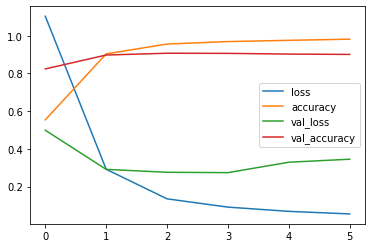

In [198]:
losses=pd.DataFrame(model.history.history)
losses.plot()